In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt
import matplotlib.image as mpimage

from IPython.display import clear_output

from IPython.display import HTML
from base64 import b64encode

In [2]:
train_data_dir = "../input/kittiroadsegmentation/training/image_2/"
train_gt_dir = "../input/kittiroadsegmentation/training/gt_image_2/"
test_data_dir = "../input/kittiroadsegmentation/testing/"

In [3]:
train_size = int(len(os.listdir(train_data_dir)) * 0.8)

In [4]:
train_size

231

In [5]:
val_size = int(len(os.listdir(train_data_dir)) * 0.1)

In [6]:
val_size

28

In [7]:
test_size = int(len(os.listdir(train_data_dir)) - train_size - val_size)

In [8]:
test_size

30

In [9]:
img_size = 128
n_channels = 3
n_classes = 1

In [10]:
def parse_image(image_path : str) -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels = 3)
    image = tf.image.convert_image_dtype(image,tf.uint8)
    
    mask_path = tf.strings.regex_replace(image_path,"image_2","gt_image_2")
    mask_path = tf.strings.regex_replace(mask_path,"um_","um_road_")
    mask_path = tf.strings.regex_replace(mask_path,"umm_","umm_road_")
    mask_path = tf.strings.regex_replace(mask_path,"uu_","uu_road_")
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels = 3)
    
    non_road_label = np.array([255,0,0])
    road_label = np.array([255,0,255])
    other_road_label = np.array([0,0,0])
    
    mask = tf.experimental.numpy.all(mask == road_label,axis = 2)
    mask = tf.cast(mask,tf.uint8)
    mask = tf.expand_dims(mask,axis = -1)
    
    return {'image' : image,'segmentation_mask' : mask}

In [11]:
all_dataset = tf.data.Dataset.list_files(train_data_dir + '*.png')
all_dataset = all_dataset.map(parse_image)

2022-10-29 21:18:30.603791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:18:30.765642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:18:30.766456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:18:30.768712: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
all_dataset.as_numpy_iterator()

2022-10-29 21:18:33.459079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
train_dataset = all_dataset.take(train_size + val_size)
val_dataset = train_dataset.skip(train_size)
train_dataset =  train_dataset.take(train_size)
test_dataset = all_dataset.skip(train_size + val_size)

In [14]:
train_dataset

<TakeDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 1)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>

In [15]:
@tf.function
def normalize(input_image : tf.Tensor, input_mask : tf.Tensor) -> tuple:
    input_image = tf.cast(input_image,tf.float32) / 255.0
    return input_image, input_mask

In [16]:
@tf.function
def load_image_train(datapoint : dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'],(img_size,img_size))
    input_mask = tf.image.resize(datapoint['segmentation_mask'],(img_size,img_size))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image,input_mask)
    
    return input_image, input_mask

In [17]:
@tf.function
def load_image_test(datapoint : dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'],(img_size,img_size))
    input_mask = tf.image.resize(datapoint['segmentation_mask'],(img_size,img_size))
    
    input_image, input_mask = normalize(input_image,input_mask)
    
    return input_image, input_mask

In [18]:
batch_size = 32
buffer_size = 1000

In [19]:
dataset = {"train" : train_dataset, "val" : val_dataset, "test" : test_dataset}

In [20]:
dataset

{'train': <TakeDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 1)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>,
 'val': <SkipDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 1)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>,
 'test': <SkipDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 1)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>}

In [21]:
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size = buffer_size)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(batch_size)
dataset['train'] = dataset['train'].prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(batch_size)
dataset['val'] = dataset['val'].prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(batch_size)
dataset['test'] = dataset['test'].prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
print(dataset['train'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [25]:
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [26]:
print(dataset['test'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [27]:
def display_image(image):
    plt.figure(figsize = (18,18))
    
    for i in range(len(image)):
        plt.subplot(1,len(image),i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
    plt.show()

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

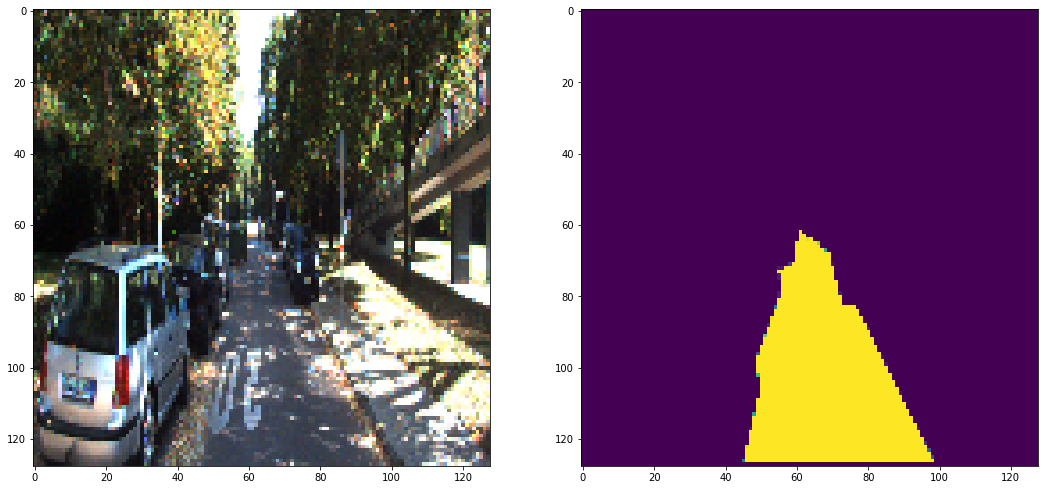

In [28]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
display_image([sample_image[0],sample_mask[0]])

## Defining the VGG Network and the last 3 pool layers

In [29]:
vgg_model = VGG16()
vgg_model.summary()

553476096/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [30]:
input_shape = (img_size,img_size, n_channels)
input_shape

(128, 128, 3)

In [31]:
inputs = Input(input_shape)

vgg_model = VGG16(include_top = False, weights = 'imagenet',input_tensor = inputs)

c1 = vgg_model.get_layer('block3_pool').output
c2 = vgg_model.get_layer('block4_pool').output
c3 = vgg_model.get_layer('block5_pool').output

u1 = UpSampling2D((2,2),interpolation = 'bilinear')(c3)
d1 = Concatenate()([u1,c2])

u2 = UpSampling2D((2,2),interpolation = 'bilinear')(d1)
d2 = Concatenate()([u2,c1])

u3 = UpSampling2D((8,8),interpolation = 'bilinear')(d2)
outputs = Conv2D(n_classes,1,activation = 'sigmoid')(u3)

model = Model(inputs, outputs, name = 'VGG_FCN8')

58900480/58889256 [==============================] - 1s 0us/step


In [32]:
model.summary()

Model: "VGG_FCN8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [33]:
m_iou = tf.keras.metrics.MeanIoU(2)
model.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = [m_iou])

In [34]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.math.round(pred_mask)
    pred_mask = tf.expand_dims(pred_mask,axis = -1)
    return pred_mask

In [35]:
def show_predictions(dataset = None, num = 1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_image([image[0],true_mask,create_mask(pred_mask)])
    else:
        inference = model.predict(sample_image)
        display_image([sample_image[0], sample_mask[0], inference[0]])

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

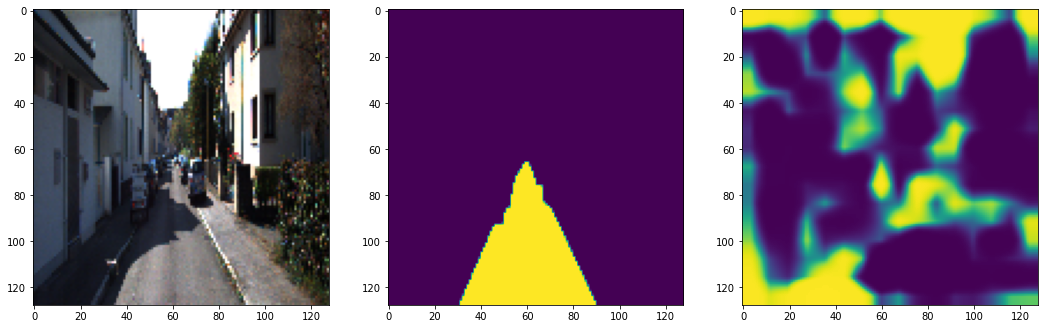

In [36]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
show_predictions()

## Train the Model

In [37]:
class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        clear_output(wait = True)
        show_predictions()
        print("\n Sample Predictions after epoch {} \n".format(epoch + 1))
        

callbacks = [
    DisplayCallback(),
    callbacks.EarlyStopping(patience = 10, verbose = 1),
    callbacks.ModelCheckpoint('best_model.h5',verbose = 1, save_best_only = True)
]

In [38]:
epochs = 200
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size

In [39]:
dataset['train']

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

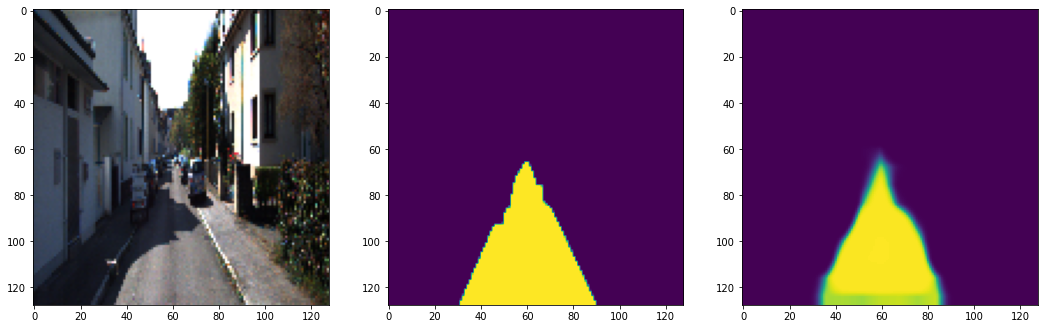

Cleanup called...
Cleanup called...



 Sample Predictions after epoch 200 



In [40]:
history = model.fit(dataset['train'], epochs = epochs,
                   steps_per_epoch = steps_per_epoch,
                   validation_data = dataset['val'],
                   validation_steps = validation_steps,
                   callbacks = callbacks)

## Making Predictions on the Test Images

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Processing Image : 0


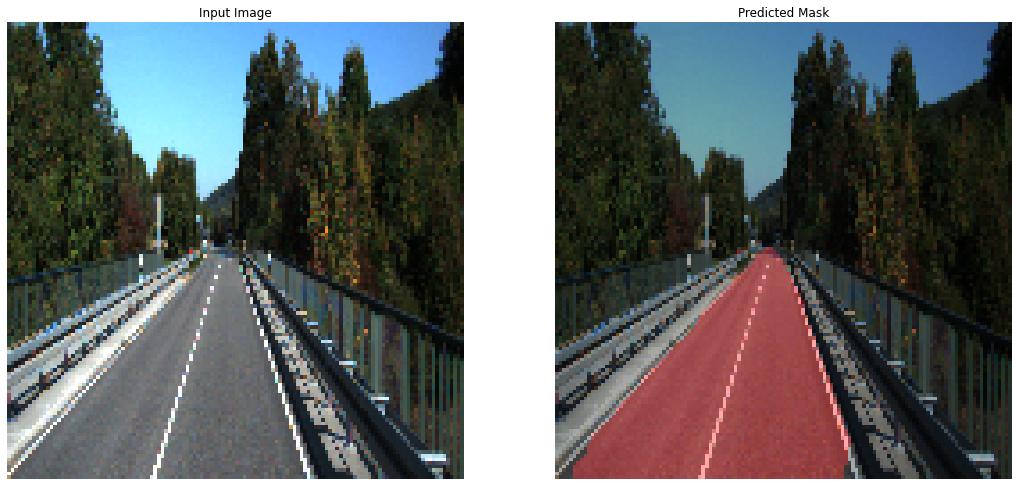

Processing Image : 1


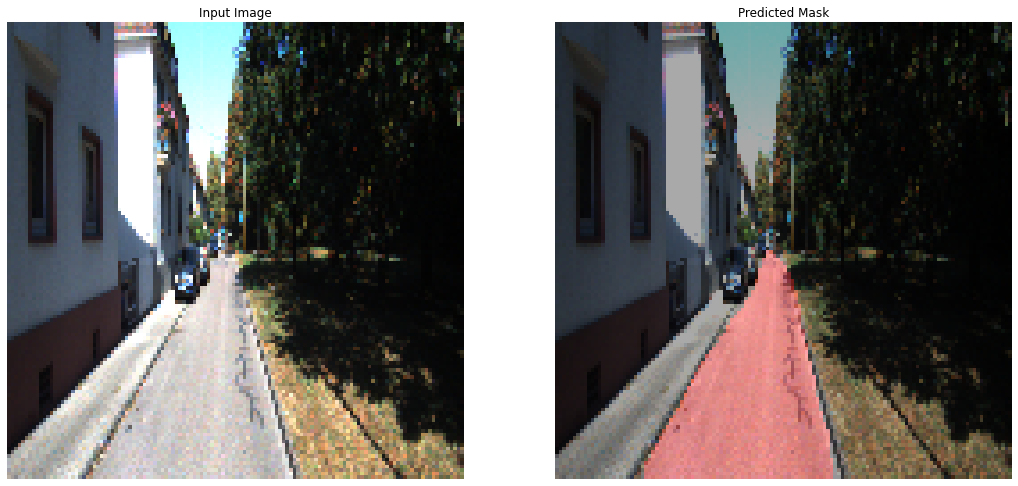

Processing Image : 2


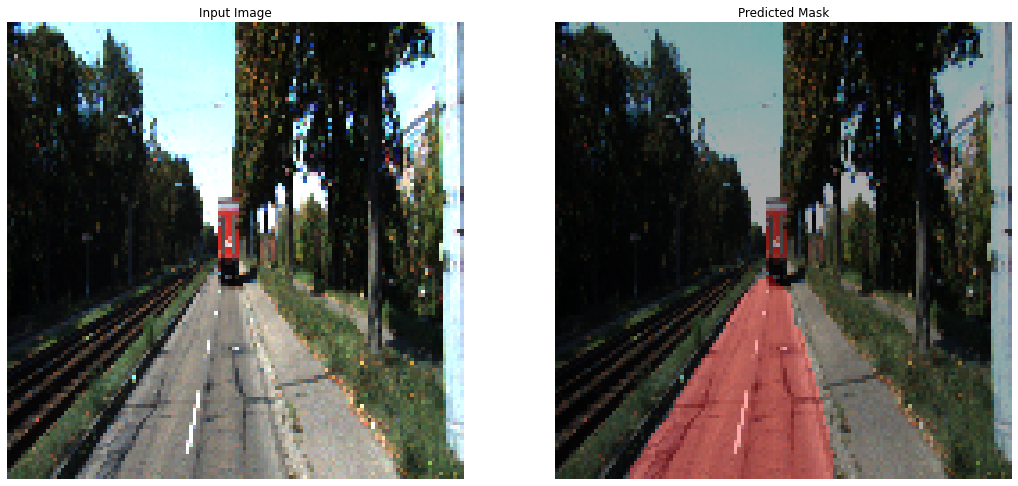

Processing Image : 3


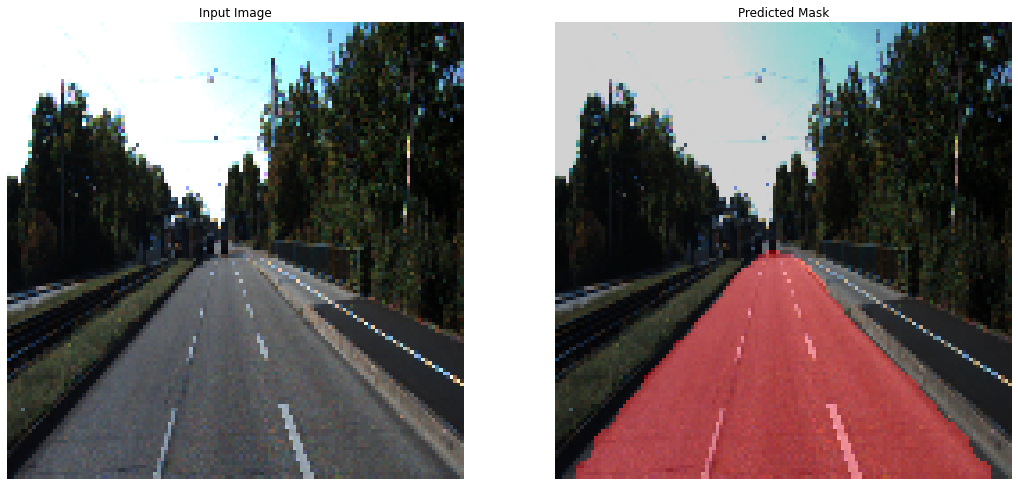

Processing Image : 4


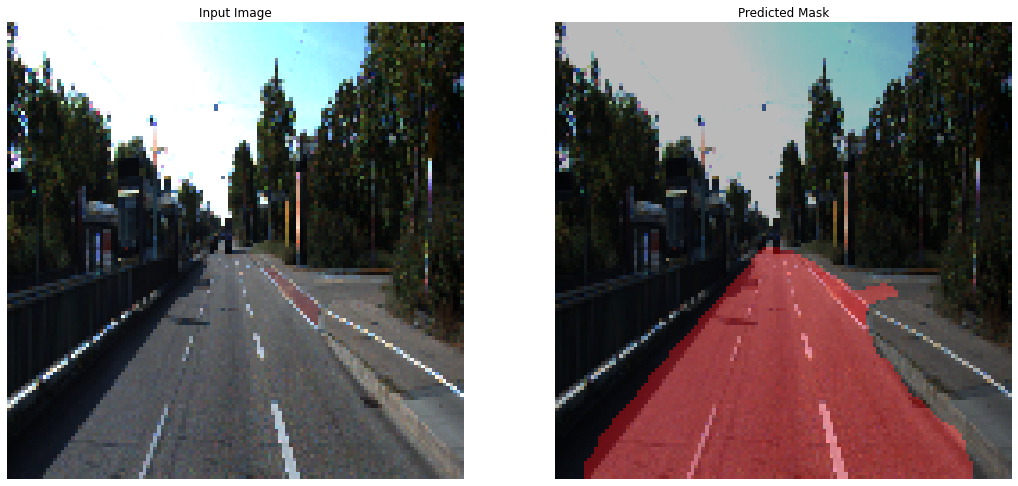

Processing Image : 5


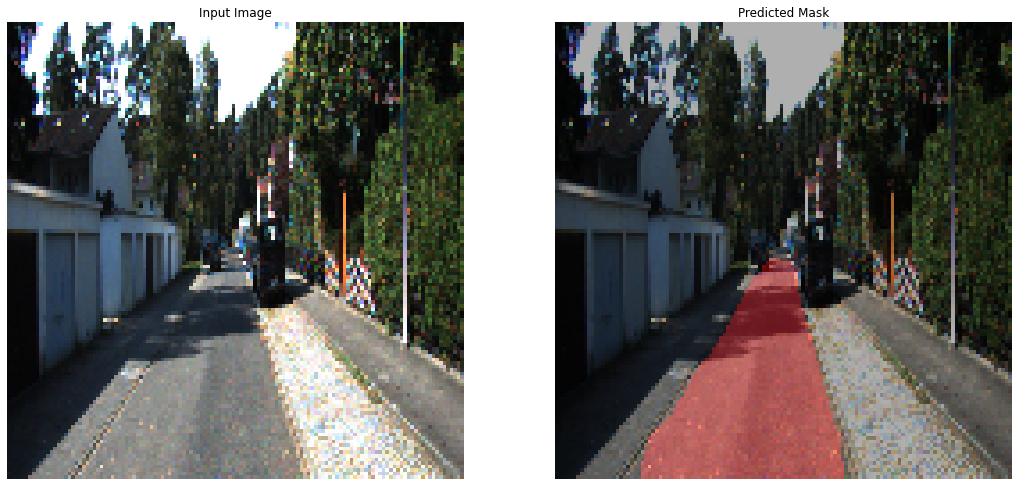

Processing Image : 6


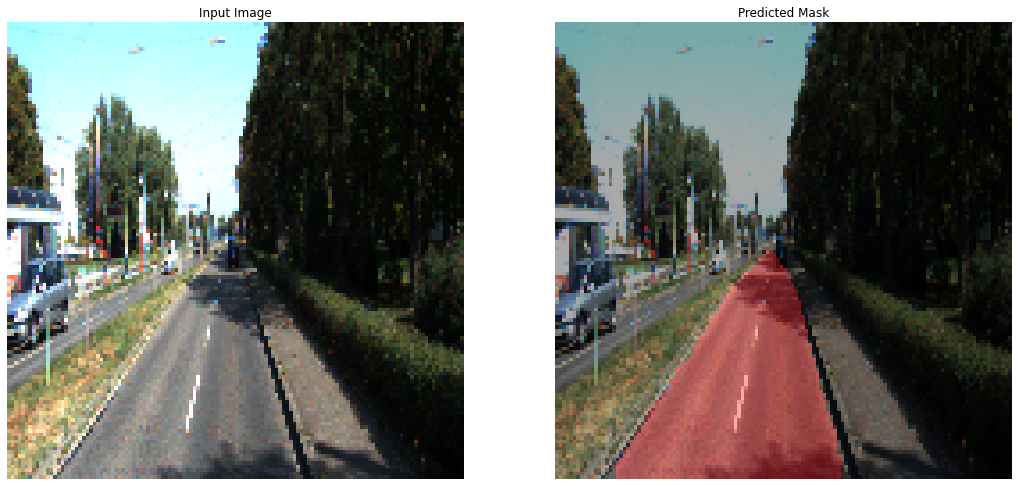

Processing Image : 7


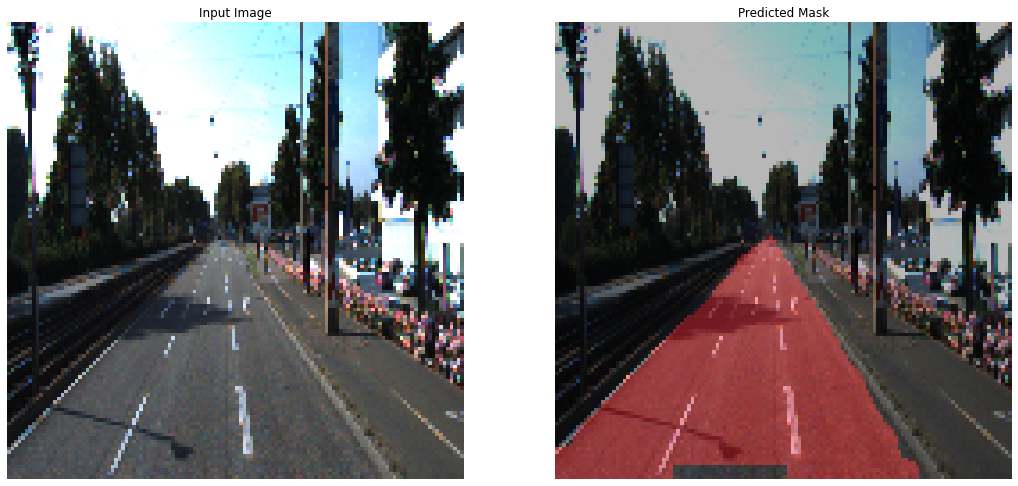

Processing Image : 8


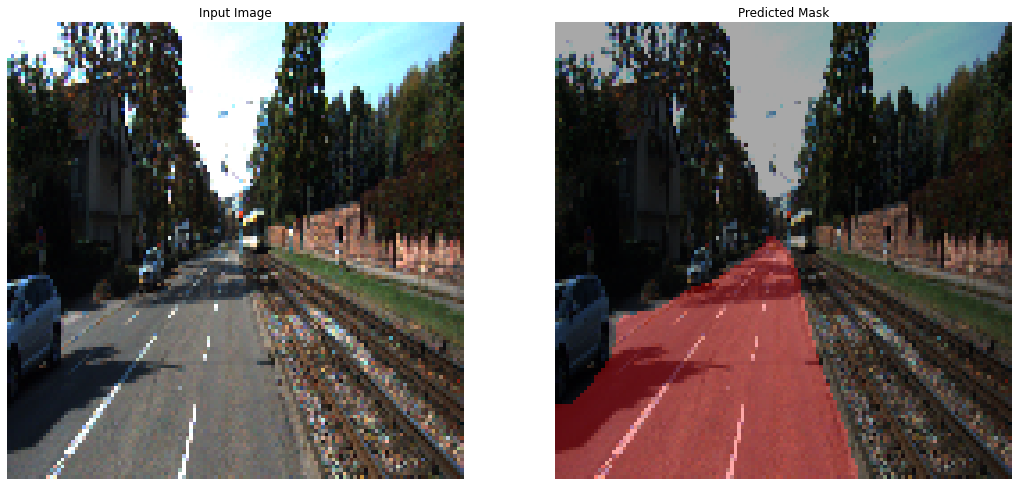

Processing Image : 9


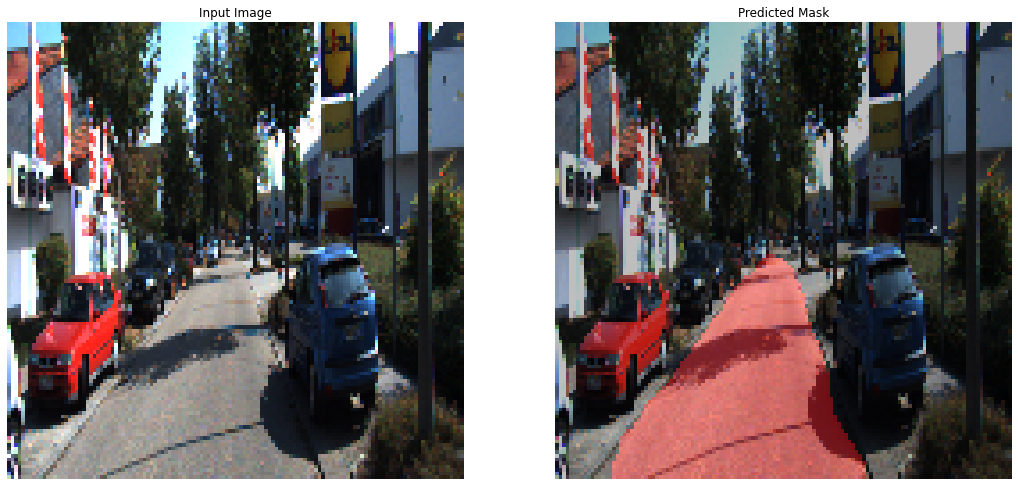

Processing Image : 10


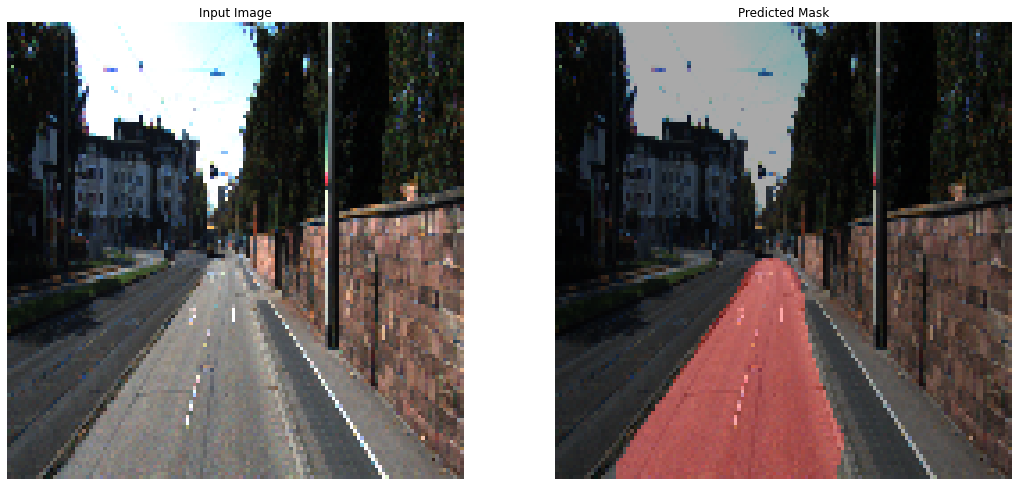

Processing Image : 11


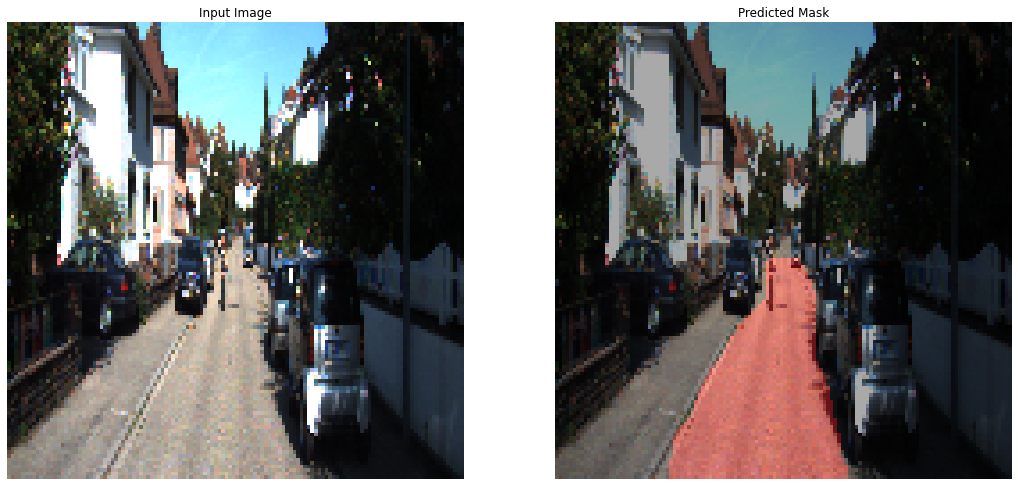

Processing Image : 12


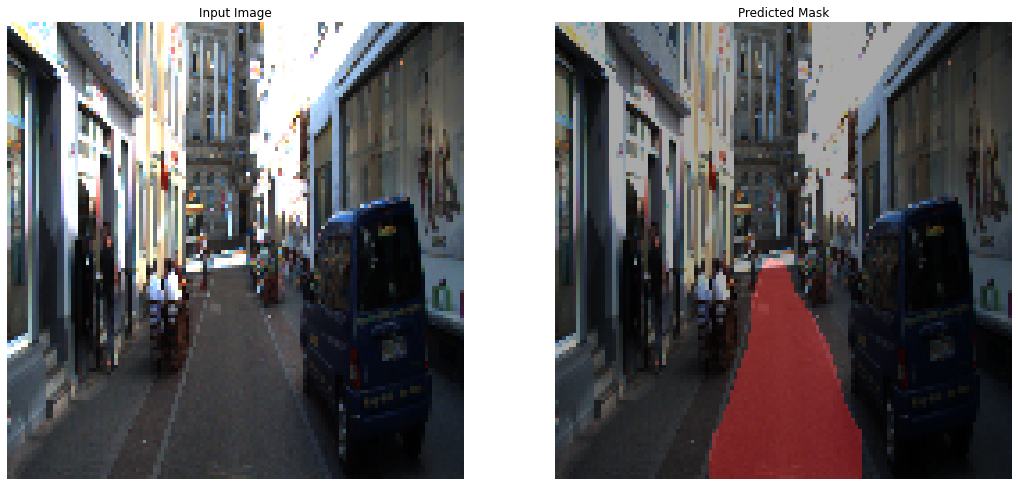

Processing Image : 13


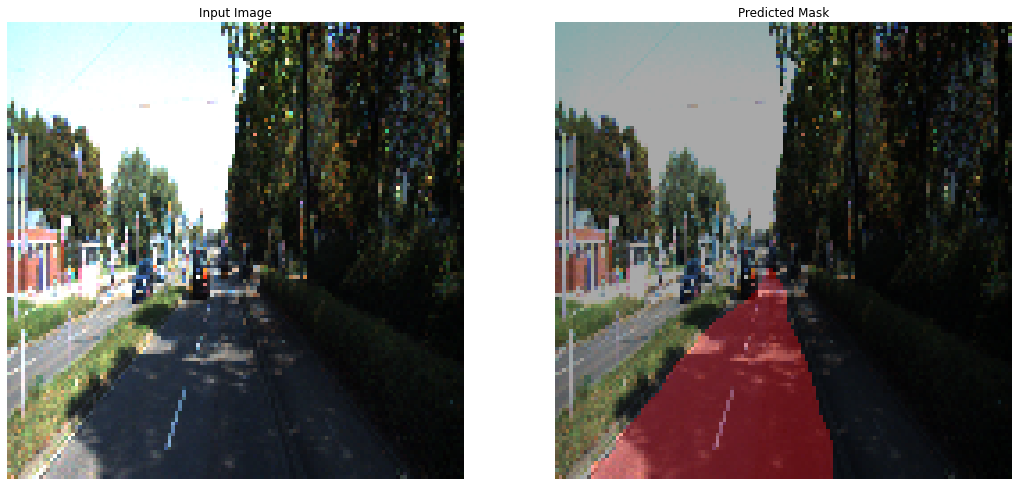

Processing Image : 14


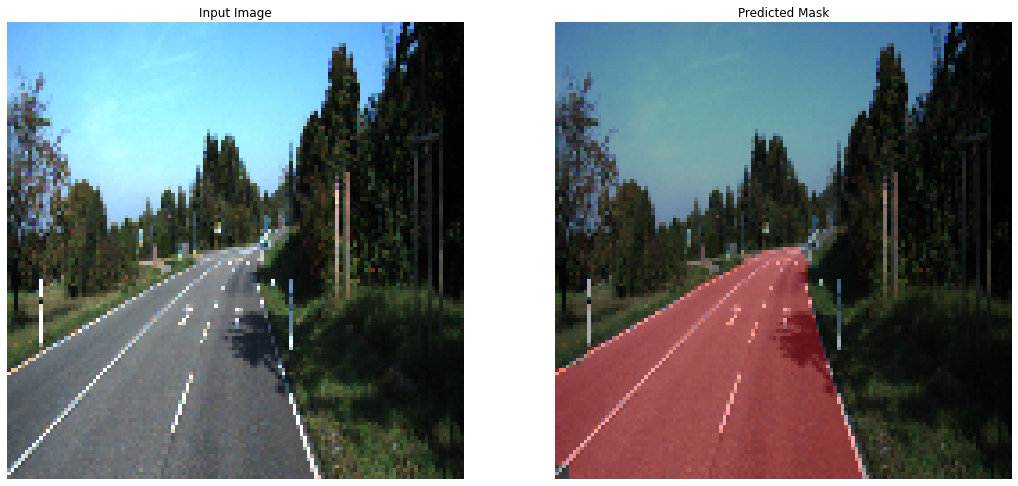

Processing Image : 15


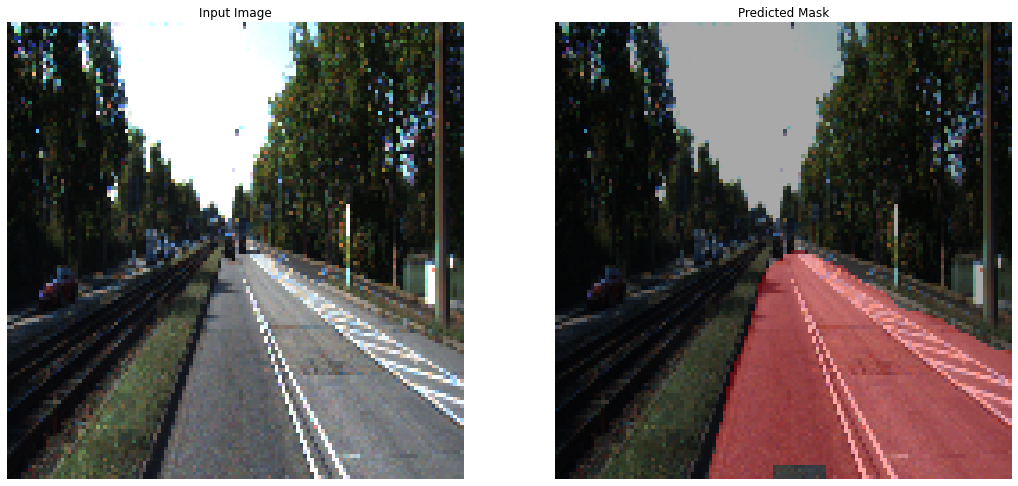

Processing Image : 16


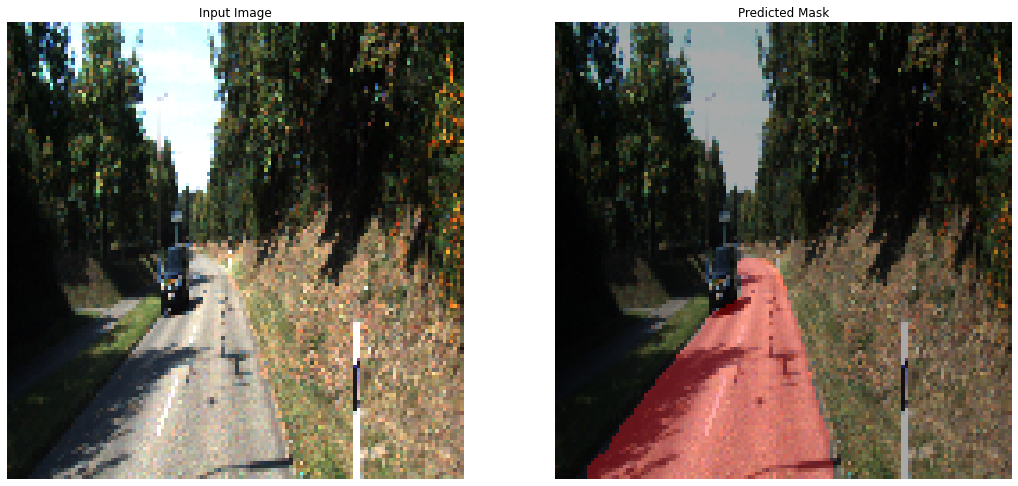

Processing Image : 17


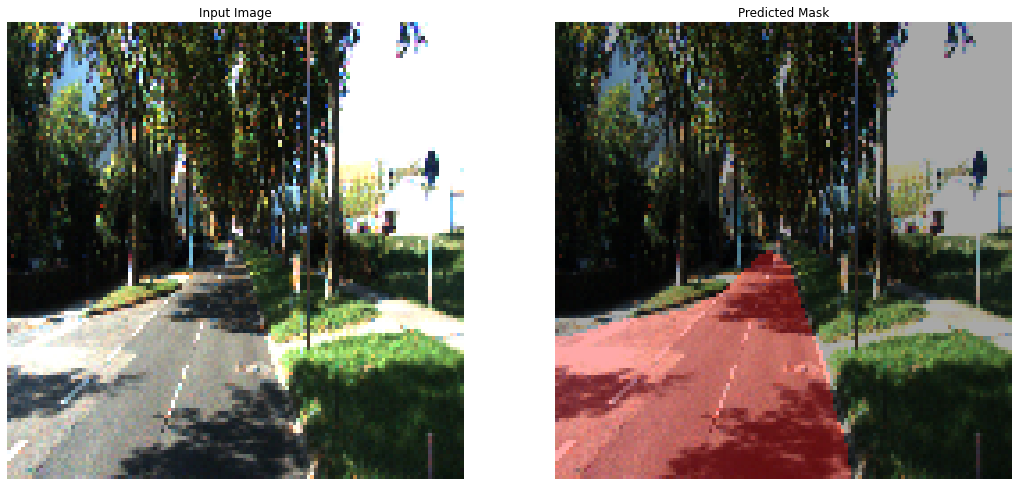

Processing Image : 18


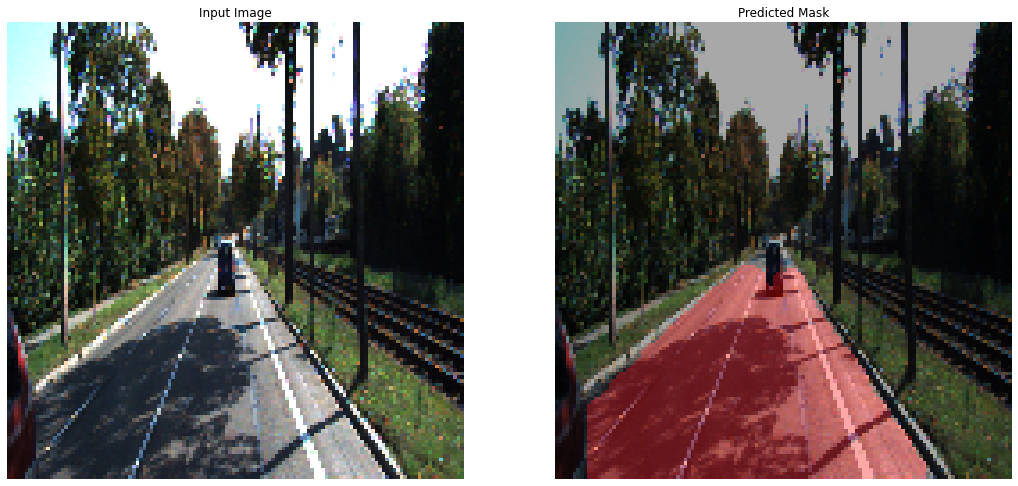

Processing Image : 19


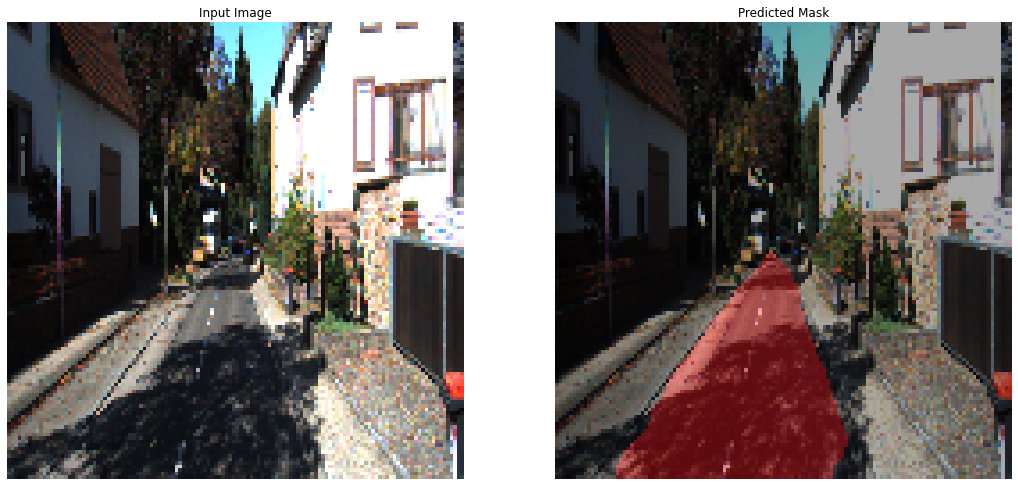

Processing Image : 20


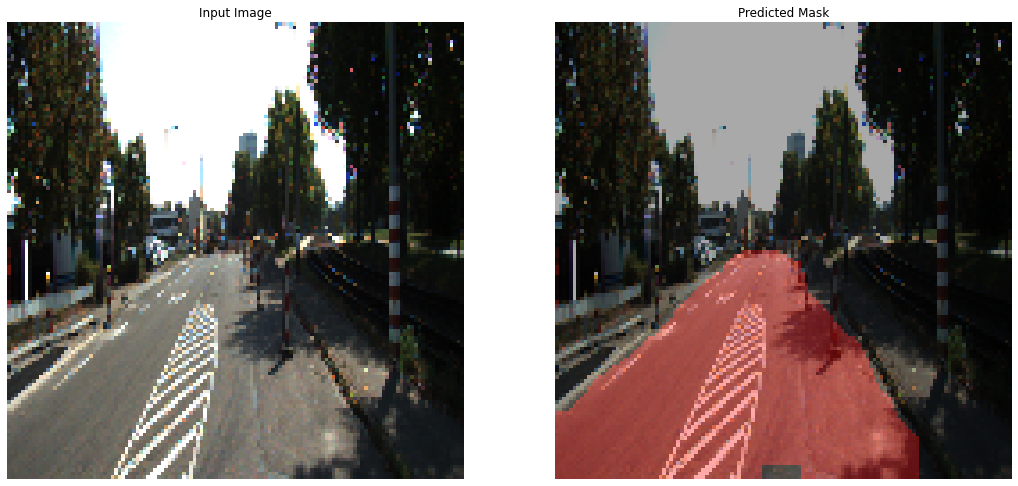

Processing Image : 21


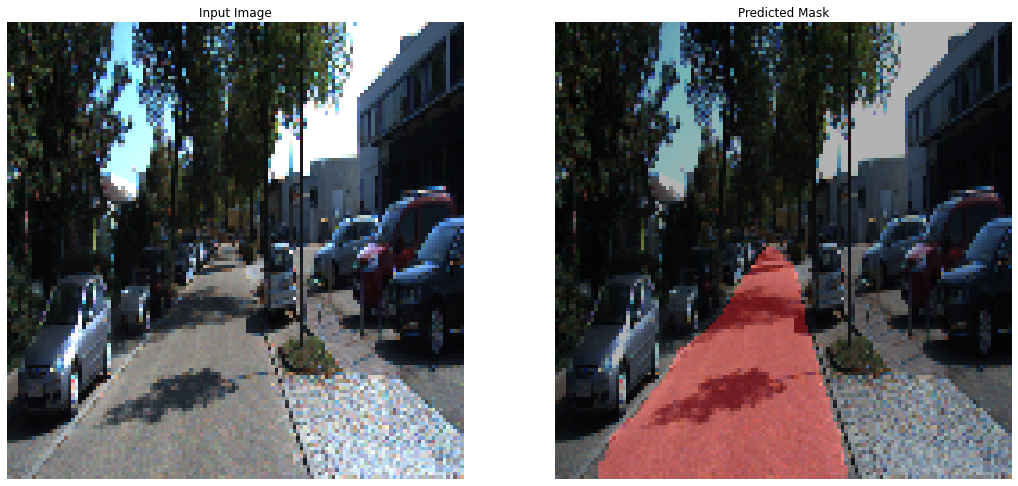

Processing Image : 22


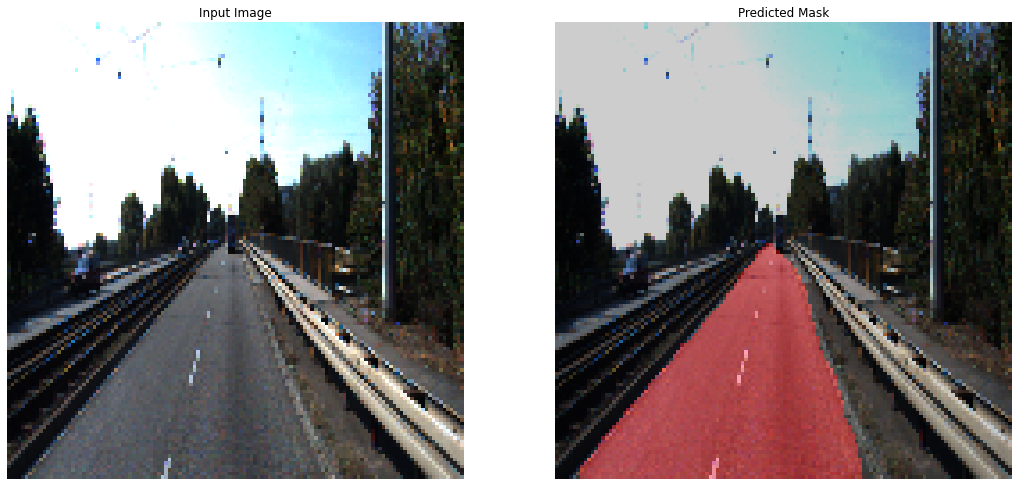

Processing Image : 23


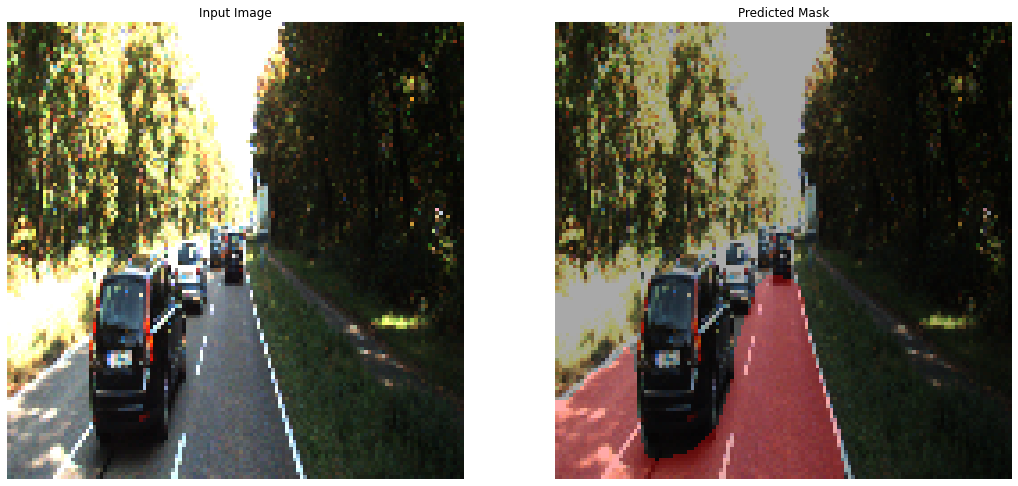

Processing Image : 24


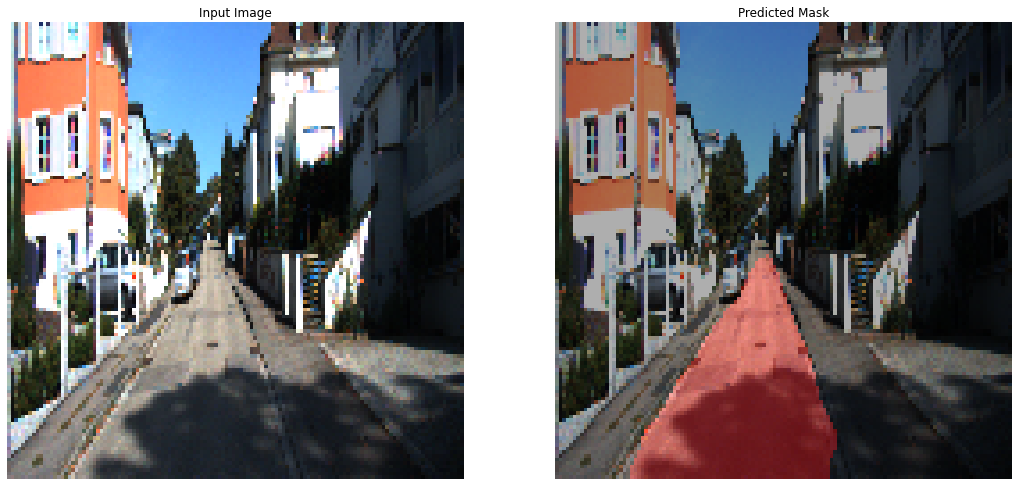

Processing Image : 25


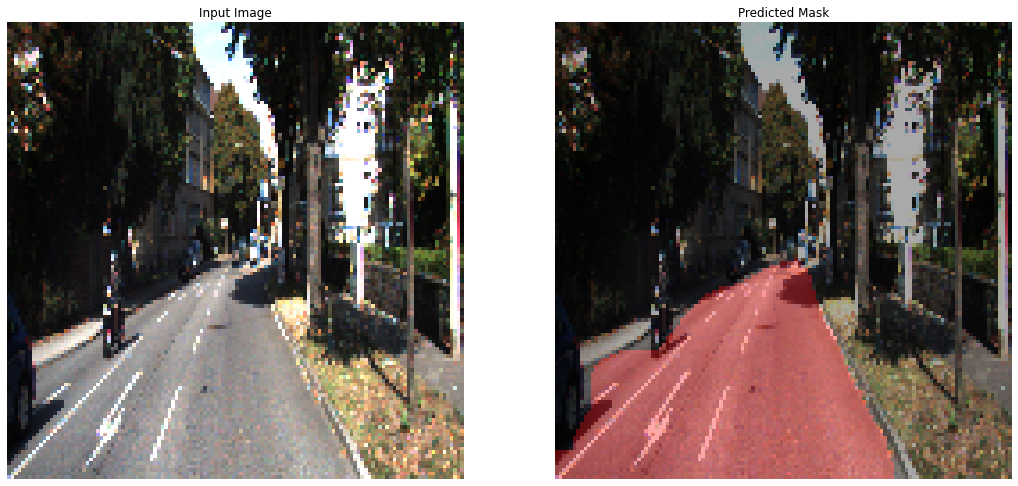

Processing Image : 26


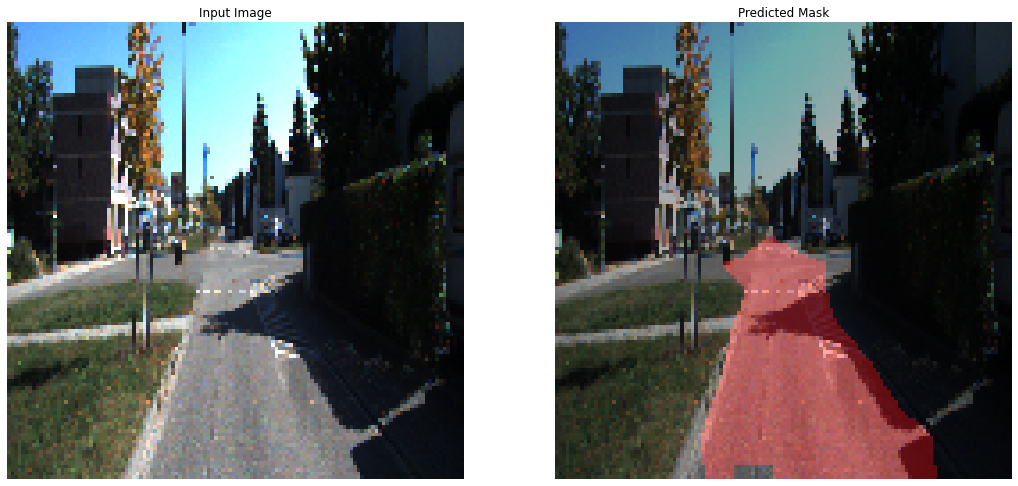

Processing Image : 27


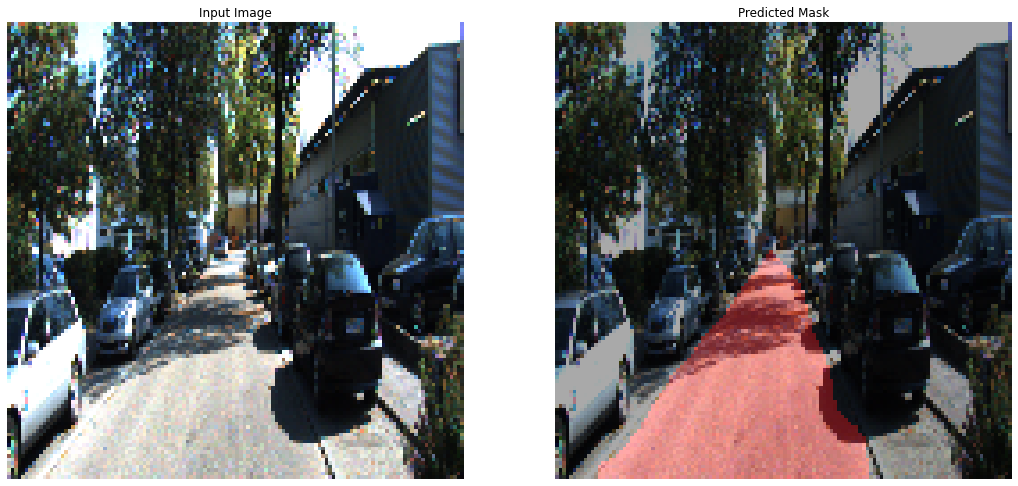

Processing Image : 28


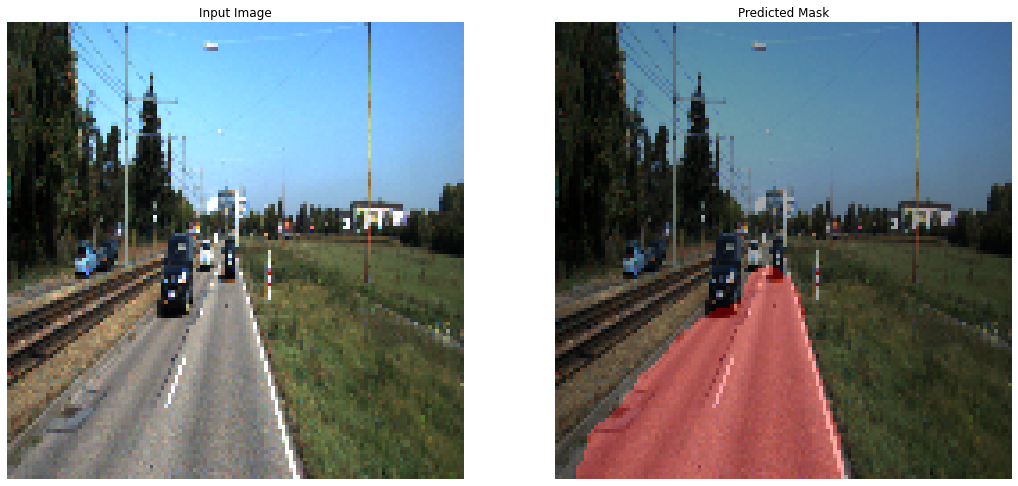

Processing Image : 29


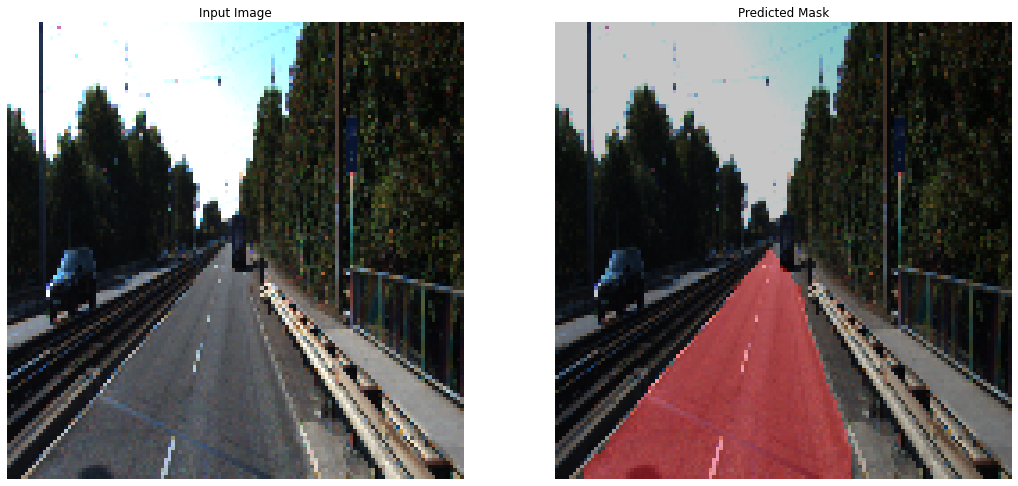

In [43]:
def weighted_image(img,initial_img, alpha = 1., beta = 0.5, gamma = 0.0):
    return cv2.addWeighted(initial_img,alpha, img, beta,gamma)

def process_image_mask(image,mask):
    mask = tf.math.round(mask)
    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask,zero_image,zero_image))
    mask = np.asarray(mask,np.float32)

    image = np.asarray(image,np.float32)
    final_image = weighted_image(mask,image)

    return final_image

def save_predictions(dataset):
    index = 0
    for batch_image, batch_mask in dataset:
        for image, mask in zip(batch_image, batch_mask):
            print("Processing Image : {}".format(index))
            pred_mask = model.predict(tf.expand_dims(image,axis = 0))
            save_sample([image,process_image_mask(image,pred_mask[0])],index)
            index += 1

def save_sample(display_list, index):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.savefig(f"outputs/{index}.png")
    plt.show()           

# os.mkdir("outputs")
save_predictions(dataset['test'])